In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from sklearn import set_config
set_config(transform_output='pandas')

df = pd.read_csv('cars.csv')
df

,year,make,model,trim,body,transmission,state,condition,odometer,color,mmr,sellingprice
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,20500.0,21500.0
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,20800.0,21500.0
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,31900.0,30000.0
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,27500.0,27750.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,66000.0,67000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
460901,2011,BMW,5 Series,528i,Sedan,automatic,fl,39.0,66403.0,white,20300.0,22800.0
460902,2012,Ram,2500,Power Wagon,Crew Cab,automatic,wa,5.0,54393.0,white,30200.0,30800.0
460903,2012,BMW,X5,xDrive35d,SUV,automatic,ca,48.0,50561.0,black,29800.0,34000.0
460904,2015,Nissan,Altima,2.5 S,sedan,automatic,ga,38.0,16658.0,white,15100.0,11100.0


In [3]:
color =['—']
df = df[~df['color'].str.strip().str.lower().isin([color.lower() for color in color])]

df['color'].unique()

array(['white', 'gray', 'black', 'red', 'silver', 'brown', 'beige',
       'blue', 'purple', 'burgundy', 'gold', 'yellow', 'green',
       'charcoal', 'orange', 'off-white', 'turquoise', 'pink', 'lime'],
      dtype=object)

In [4]:
df = df.dropna()
df.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
mmr             0
sellingprice    0
dtype: int64

In [5]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,438988.000000,438988.000000,438988.000000,438988.000000,438988.000000
mean,2010.220585,30.687483,66819.878978,13851.439447,13700.755955
std,3.805366,13.282640,52002.104145,9476.794770,9558.521386
min,1990.000000,1.000000,1.000000,25.000000,1.000000
25%,2008.000000,24.000000,28376.000000,7550.000000,7300.000000
50%,2012.000000,35.000000,51321.000000,12350.000000,12200.000000
75%,2013.000000,41.000000,96454.000000,18250.000000,18100.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


In [6]:
df.duplicated().sum()

np.int64(0)

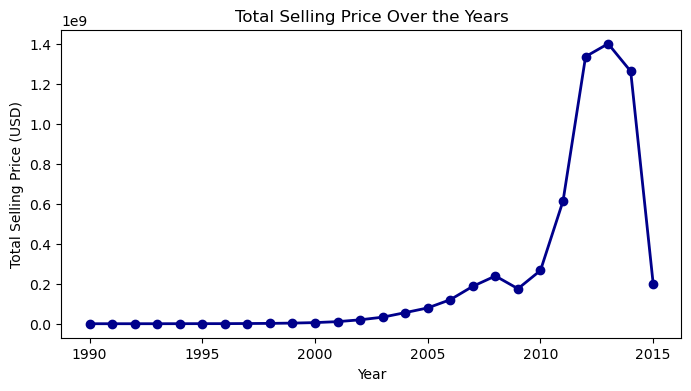

In [29]:
yearly_totals = df.groupby('year')['sellingprice'].sum().sort_index()

plt.figure(figsize=(8,4))
plt.plot(yearly_totals.index, yearly_totals.values, marker='o', color='darkblue', linewidth=2)

plt.title('Total Selling Price Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Selling Price (USD)')

plt.show()

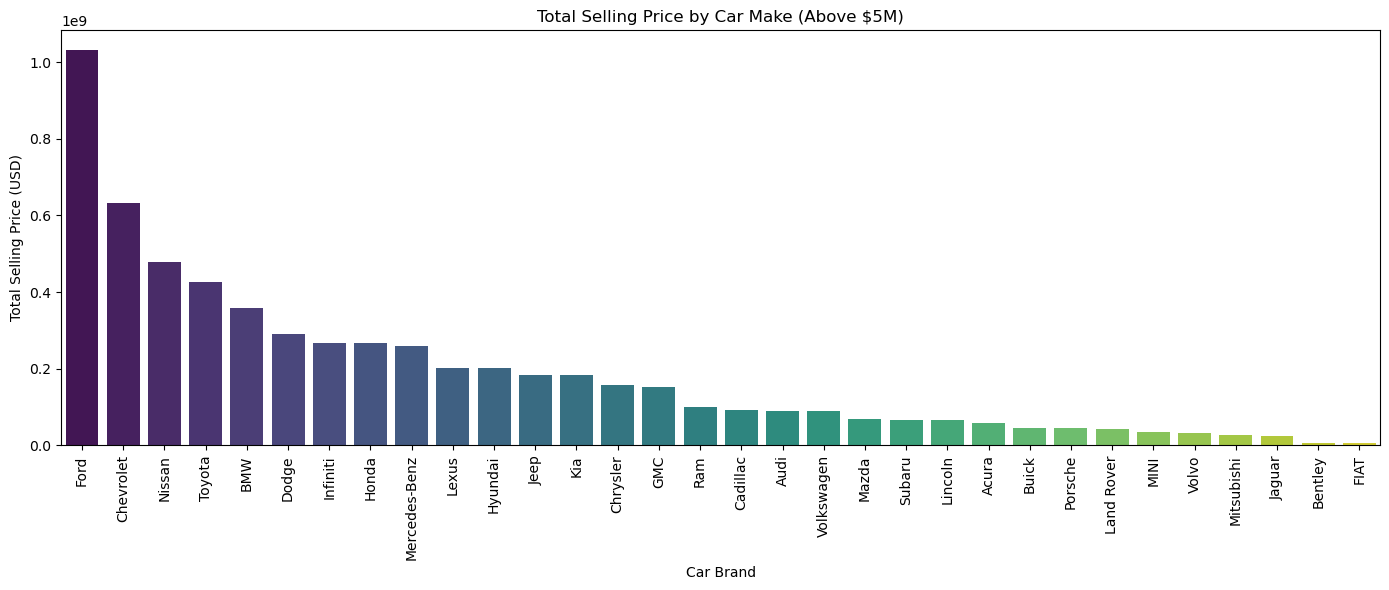

In [27]:
make_prices = df.groupby('make')['sellingprice'].sum()

filtered_prices = make_prices[make_prices > 5_000_000].sort_values(ascending=False)


plt.figure(figsize=(14,6))
sns.barplot(x=filtered_prices.index, y=filtered_prices.values, palette='viridis')

plt.xticks(rotation=90)
plt.title('Total Selling Price by Car Make (Above $5M)')
plt.xlabel('Car Brand')
plt.ylabel('Total Selling Price (USD)')
plt.tight_layout()
plt.show()

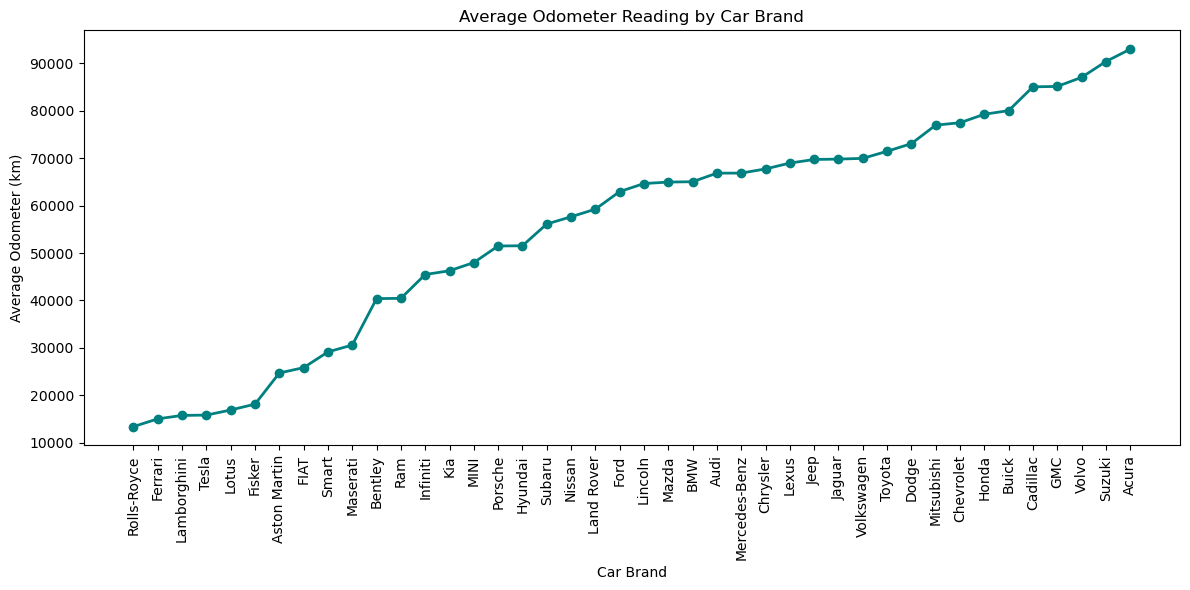

In [26]:
avg_odometer = df.groupby('make')['odometer'].mean().sort_values()

plt.figure(figsize=(12,6))
plt.plot(avg_odometer.index, avg_odometer.values, marker='o', color='teal', linewidth=2)

plt.xticks(rotation=90)
plt.title('Average Odometer Reading by Car Brand')
plt.xlabel('Car Brand')
plt.ylabel('Average Odometer (km)')
plt.tight_layout()
plt.show()

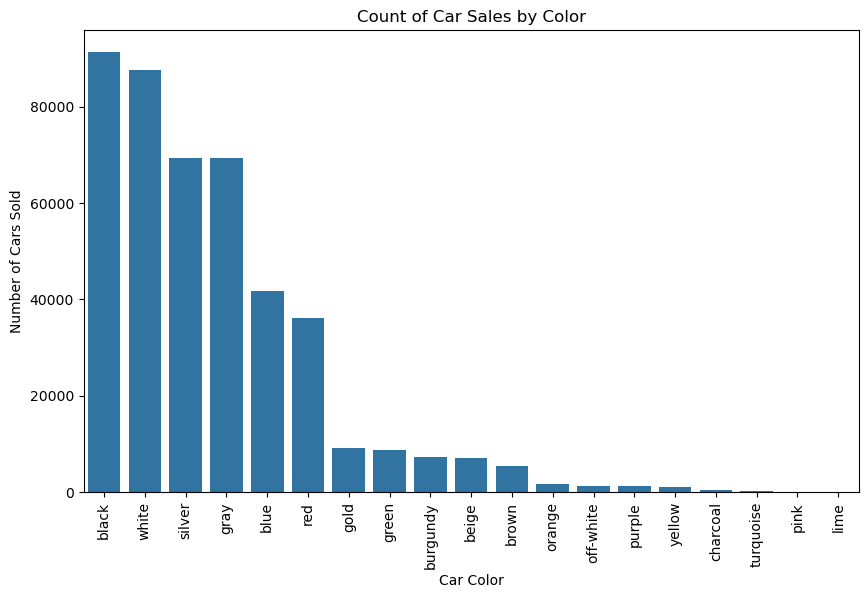

In [30]:
color_counts = df['color'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=color_counts.index, y=color_counts.values)

plt.title('Count of Car Sales by Color')
plt.xlabel('Car Color')
plt.ylabel('Number of Cars Sold')
plt.xticks(rotation=90)
plt.show()

In [31]:
df_sampled = df.sample(frac=0.3, random_state=42)  # Keep 30% of data

In [32]:
X = ['year', 'odometer','make', 'model', 'condition','trim','transmission']
y = 'sellingprice'
X_train, X_test, y_train, y_test = train_test_split(df_sampled[X], df_sampled[y], test_size=0.2, random_state=42)

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature groups
num = ['year', 'odometer']
cat = ['make', 'model', 'trim', 'transmission']
ord = ['condition']

# Define preprocessing pipelines
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_pipeline, ord),
    ('categorical', categorical_pipeline, cat),
    ('numeric', numeric_pipeline, num)
])


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("X_train_processed :", X_train_processed)


X_train_processed :         ordinal__condition  categorical__make_Acura  \
215126                24.0                      0.0   
22681                 24.0                      0.0   
317168                37.0                      0.0   
224737                27.0                      0.0   
427377                26.0                      0.0   
...                    ...                      ...   
445862                31.0                      0.0   
347201                13.0                      0.0   
385825                23.0                      0.0   
188440                28.0                      0.0   
408279                16.0                      0.0   

        categorical__make_Aston Martin  categorical__make_Audi  \
215126                             0.0                     0.0   
22681                              0.0                     0.0   
317168                             0.0                     0.0   
224737                             0.0                 

In [34]:
X_train_processed

,ordinal__condition,categorical__make_Acura,categorical__make_Aston Martin,categorical__make_Audi,categorical__make_BMW,categorical__make_Bentley,categorical__make_Buick,categorical__make_Cadillac,categorical__make_Chevrolet,categorical__make_Chrysler,...,categorical__trim_xDrive30i,categorical__trim_xDrive35d,categorical__trim_xDrive35i,categorical__trim_xDrive35i Premium,categorical__trim_xDrive48i,categorical__trim_xDrive50i,categorical__transmission_automatic,categorical__transmission_manual,numeric__year,numeric__odometer
215126,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.470700,-0.497999
22681,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.470700,-0.949156
317168,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.732068,-0.578785
224737,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.470700,-0.148236
427377,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.209331,1.317234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445862,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.574775,0.490064
347201,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.620249,1.353876
385825,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.732068,-0.254323
188440,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.993437,-0.663429


In [35]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators= 50)
rf_model.fit(X_train_processed, y_train)

preds = rf_model.predict(X_test_processed)

mae = mean_absolute_error(y_test, preds)
print(f"Mean Absolute Error: ${mae:,.2f}")

baseline_mae = mean_absolute_error(y_test, [y_test.mean()] * len(y_test))
print(f"Baseline Mean Absolute Error: ${baseline_mae:,.2f}")

rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Root Mean Squared Error: ${rmse:,.2f}")

Mean Absolute Error: $1,504.52
Baseline Mean Absolute Error: $6,936.21
Root Mean Squared Error: $2,638.73


In [36]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train_processed, y_train)

predz = lin_model.predict(X_test_processed)

mae1 = mean_absolute_error(y_test, predz)
print(f"Mean Absolute Error: ${mae1:,.2f}")

rmse1 = np.sqrt(mean_squared_error(y_test, predz))
print(f"Root Mean Squared Error: ${rmse1:,.2f}")

baseline_mae1 = mean_absolute_error(y_test, [y_test.mean()] * len(y_test))
print(f"Baseline Mean Absolute Error: ${baseline_mae1:,.2f}")

Mean Absolute Error: $2,166.35
Root Mean Squared Error: $3,481.04
Baseline Mean Absolute Error: $6,936.21


In [37]:
mae_percent = (mae / y_test.mean()) * 100
rmse_percent = (rmse / y_test.mean()) * 100

In [41]:
print("mae% :", mae_percent)
print("rmse% :", rmse_percent)

mae% : 11.002126366562088
rmse% : 19.29626838126779


In [43]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 1.4 MB/s eta 0:01:44
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   -------------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
from xgboost import XGBRegressor

for n in [50, 100, 150, 200]:
    model = XGBRegressor(n_estimators=n)
    model.fit(X_train_processed, y_train)
    preds = model.predict(X_test_processed)
    mae = mean_absolute_error(y_test, preds)
    print(f"n_estimators={n} -> MAE: ${mae:,.2f}")

n_estimators=50 -> MAE: $2,373.10
n_estimators=100 -> MAE: $1,942.35
n_estimators=150 -> MAE: $1,724.01
n_estimators=200 -> MAE: $1,607.14
